In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [2]:
import tensorflow as tf
import numpy as np

from tqdm import tqdm    # tqdm

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

## 데이터 준비

In [3]:
'''
import tarfile

# 1. wget을 사용하여 파일 다운로드
url = "https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz"
filename = "korean-english-park.train.tar.gz"

# 다운로드 명령어 실행
!wget -O {filename} {url}
'''

--2024-07-09 02:12:12--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2024-07-09 02:12:12--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean-eng

In [4]:
'''
# tar.gz 파일 추출
extracted_dir = "./data"

def extract_tarfile(file_path, extract_path):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=extract_path)

# 파일 추출 실행
extract_tarfile(filename, extracted_dir)
'''

Extracted files:
./data/korean-english-park.train.ko
./data/korean-english-park.train.en


In [3]:
# 추출된 파일 확인
extracted_dir = "./data"
filenames = []
print("Extracted files:")
for root, dirs, files in os.walk(extracted_dir):
    filenames=files
    for name in files:
        print(os.path.join(root, name))

Extracted files:
./data/korean-english-park.train.ko
./data/korean-english-park.train.en
./data/korean-english-park.train.tar.gz


## 데이터 확인

In [4]:
# 한국어 데이터
path_to_file = './data/'+filenames[0]
with open(path_to_file, "r") as f:
    kor_raw = f.read().splitlines()

print("Data Size:", len(kor_raw))
print("Example:")

for sen in kor_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


In [5]:
# 영어 데이터
path_to_file = './data/'+filenames[1]
with open(path_to_file, "r") as f:
    eng_raw = f.read().splitlines()

print("Data Size:", len(eng_raw))
print("Example:")

for sen in eng_raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


## 데이터 정제

### 중복 제거
set() 활용

In [6]:
paired_list = list(zip(kor_raw, eng_raw))
print("중복 제거 전 데이터 길이: ", len(paired_list))
print(paired_list[0])

중복 제거 전 데이터 길이:  94123
('개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"', 'Much of personal computing is about "can you top this?"')


In [7]:
cleaned_corpus = list(set(paired_list))
print("중복 제거 후 데이터 길이: ", len(cleaned_corpus))
print(cleaned_corpus[0])

중복 제거 후 데이터 길이:  78968
('리글, 블레이어 그리고 클레멘츠는 5일간 바그다드 인근 발라드 공군기지와 또 다른 2개의 군 기지 등 많은 곳을 방문했다.', 'Riggle, Clements and Bleyer visited several bases including Balad Air Force Base near Baghdad and two forward operating bases over five days.')


### 전처리

In [8]:
def kor_preprocess_sentence(sentence):
    sentence = re.sub(r"([?!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣ㅏ-ㅣ?.!,]+", " ", sentence)

    sentence = sentence.strip()
    
    return sentence

In [9]:
def eng_preprocess_sentence(sentence):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    sentence = '<start> ' + sentence
    sentence += ' <end>'
    
    return sentence

In [10]:
enc_corpus = []
dec_corpus = []

for pair in cleaned_corpus:
    kor = pair[0]
    eng = pair[1]

    enc_corpus.append(kor_preprocess_sentence(kor))
    dec_corpus.append(eng_preprocess_sentence(eng))

print("Korean:", enc_corpus[100])
print("English:", dec_corpus[100])

Korean: 말콤 브루스 위원회장은 난민들을 돕기 위해서 추가적인 금액이 필요하다고 말했다 .
English: <start> the head of the committee , malcolm bruce , said the extra money was needed to help displaced people . <end>


## 토큰화

In [11]:
from konlpy.tag import Mecab
from collections import Counter

In [12]:
def konlpy_tokenize(corpus):
    print("한국어 데이터 토큰화 시작")
    # 토큰화
    tokenizer = Mecab()
    tokenized = []
    for sentence in tqdm(corpus):
        tokenized.append(tokenizer.morphs(sentence))
        
    # 사전 구성
    words = np.concatenate(tokenized).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000)
    vocab = [key for key, _ in counter]
    word2idx = {word:index+2 for index, word in enumerate(vocab)}    # 인덱스 0, 1은 패딩과 unk 토큰을 위해 비워둠
    word2idx[0] = '<pad>'
    word2idx[1] = '<unk>'
    
    # 텍스트를 정수 시퀀스로 변환
    tensor = [[word2idx.get(word, 1) for word in sentence] for sentence in tokenized]  # 없는 단어는 0으로
    
    return tensor, word2idx

In [13]:
def space_tokenize(corpus):
    print("영어 데이터 토큰화 시작")
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    # 공백 기준 토큰화
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    return tensor, tokenizer

In [14]:
# 토큰화하기
enc_input, enc_word2idx = konlpy_tokenize(enc_corpus)
dec_input, dec_tokenizer = space_tokenize(dec_corpus)

한국어 데이터 토큰화 시작


100%|██████████| 78968/78968 [00:12<00:00, 6555.04it/s]


영어 데이터 토큰화 시작


### 토큰 개수 확인

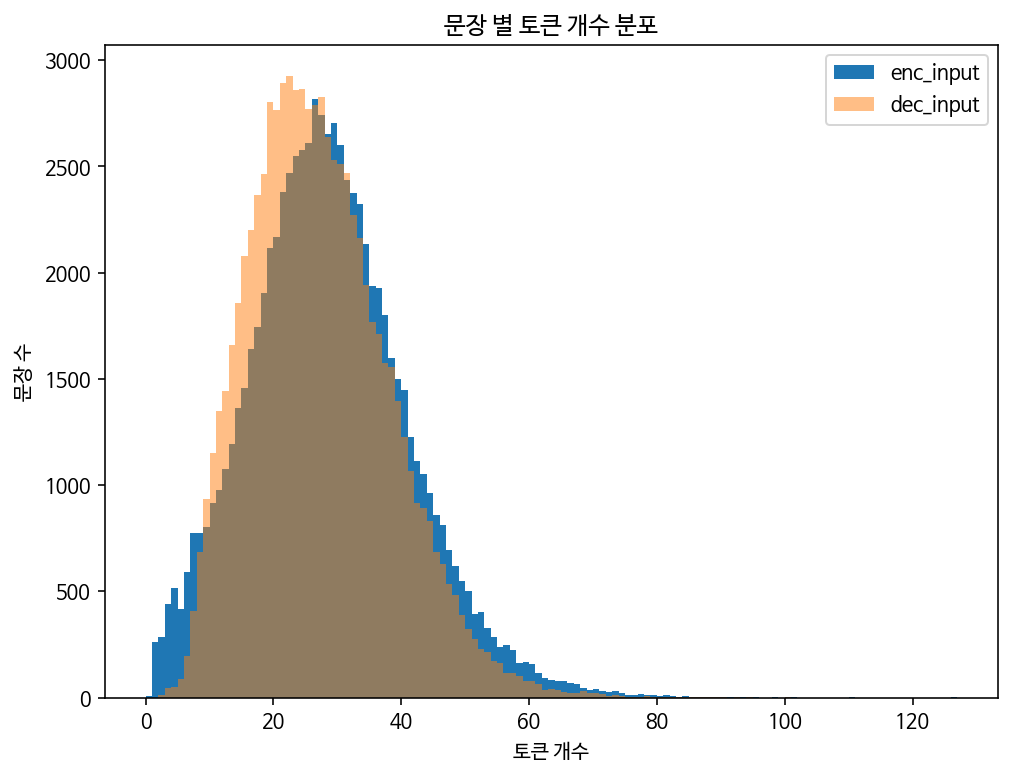

토큰 개수가 40 이상인 문장의 비율
인코더 입력: 15.14%
디코더 입력: 11.05%


In [15]:
# 각 문장의 토큰 개수 계산
enc_token_lengths = [len(tokens) for tokens in enc_input]
dec_token_lengths = [len(tokens) for tokens in dec_input]

# 그래프로 토큰 개수 분포 확인
plt.figure(figsize=(8, 6))
plt.hist(enc_token_lengths, bins=range(0, max(enc_token_lengths) + 1, 1), label='enc_input')
plt.hist(dec_token_lengths, bins=range(0, max(dec_token_lengths) + 1, 1), label='dec_input', alpha=0.5)
plt.xlabel('토큰 개수')
plt.ylabel('문장 수')
plt.title('문장 별 토큰 개수 분포')
plt.legend()
plt.show()

# 토큰 개수 40 이상인 문장 비율 확인
SEQ_LENGTH=40
print("토큰 개수가 40 이상인 문장의 비율")
cnt=0
for enc_seq in enc_input:
    if len(enc_seq) > SEQ_LENGTH:
        cnt+=1
print("인코더 입력: %.2f%%" % (cnt/len(enc_input)*100))
cnt=0
for dec_seq in dec_input:
    if len(dec_seq) > SEQ_LENGTH:
        cnt+=1
print("디코더 입력: %.2f%%" % (cnt/len(dec_input)*100))

In [16]:
enc_input_filtered = []
dec_input_filtered = []

for enc_seq, dec_seq in zip(enc_input, dec_input):
    if len(enc_seq) <= SEQ_LENGTH and len(dec_seq) <= SEQ_LENGTH:
        enc_input_filtered.append(enc_seq)
        dec_input_filtered.append(dec_seq)

In [36]:
enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input_filtered, padding='post')
dec_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input_filtered, padding='post')

print(enc_input.shape)
print(dec_input.shape)

(63139, 40)
(63139, 40)


## 모델링
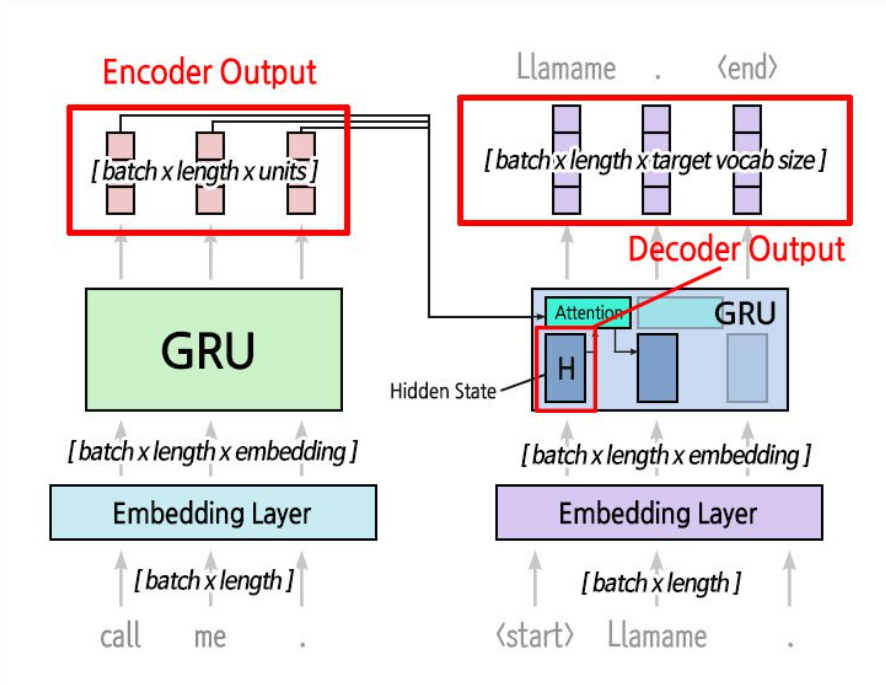

In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)   # [batch x length x units]
        h_dec = tf.expand_dims(h_dec, 1)    # [batch x 1 x units]
        h_dec = self.w_dec(h_dec)   # [batch x 1 x units]

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))   # [batch x length x 1]
        attn = tf.nn.softmax(score, axis=1) # [batch x length x 1]
        context_vec = attn * h_enc  # [batch x length x units]
        context_vec = tf.reduce_sum(context_vec, axis=1)    # [batch x units]
        return context_vec, attn

In [20]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        # TODO: Awesome Encoder Modules
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

    def call(self, x):
        # TODO: Awesome Process
        x = self.embedding(x)
        states = self.gru(x)
        return states

In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        # TODO: Awesome Decoder Modules
        self.attention = BahdanauAttention(dec_units)   # Attention 필수 사용!
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, x, h_dec, enc_out):
        # TODO: Awesome Process
        context_vec, attn = self.attention(enc_out, h_dec)
        x = self.embedding(x)
        x = tf.concat([x, tf.expand_dims(context_vec, axis=1)], axis=-1)    # [batch x length x (embedding_dim+units)]
        seq, state = self.gru(x)    # [batch x 1 x units], [batch x units]
        seq = tf.squeeze(seq, axis=1)   # Dense 레이어에 입력하기 위함
        seq = self.fc(seq)    # 출력 차원을 vocab_size로 변환 [batch x vocab_size]

        return seq, state, attn

In [26]:
# 코드를 실행하세요.
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_word2idx) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sample_enc = tf.random.uniform((BATCH_SIZE, SEQ_LENGTH))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 40, 1024)
Decoder Output: (64, 44566)
Decoder Hidden State: (64, 1024)
Attention: (64, 40, 1)


## 훈련
커스텀 손실 함수를 사용해야 하므로 `fit()` 사용하지 않음

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
# CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하겠지만, SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 정수 인덱스 답안 2 를 비교하여 점수를 채점하는 거죠.
# from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 패딩에 대한 처리를 해주지 않으면 <PAD> 토큰만을 생성할 확률이 굉장히 높아짐. 이 문제를 방지하기 위해 mask 사용
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [28]:
@tf.function
#  훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줌
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    batch_size = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)    # 컨텍스트 벡터 생성
        h_dec = enc_out[:, -1]    # 첫번째 스텝에서는 인코더의 마지막 hidden state를 context vector로 사용
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * batch_size, 1)    # 첫번째 스텝의 입력은 시작 토큰

        for t in range(1, tgt.shape[1]):    # 입력 문장의 길이만큼 반복(pad_sequences의 인자)
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)    # 현재 스텝까지의 실제값과 예측값 비교
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))    # 배치 평균 loss

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [31]:
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_input.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_input[idx:idx+BATCH_SIZE],
                                dec_input[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  1: 100%|██████████| 987/987 [11:02<00:00,  1.49it/s, Loss 3.8233]


## 평가 
번역 성능 평가 및 attention map 시각화

In [47]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((SEQ_LENGTH, SEQ_LENGTH))
    
    sentence = kor_preprocess_sentence(sentence)
    tokenizer = Mecab()
    tokenized_sentence = tokenizer.morphs(sentence)
    inputs = [[enc_word2idx.get(word, 1) for word in sentence]]
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=SEQ_LENGTH,
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(SEQ_LENGTH):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))

Input: 말콤 브루스 위원회장은 난민들을 돕기 위해서 추가적인 금액이 필요하다고 말했다 .
Predicted translation: the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the 


/tmp/ipykernel_141/1233599763.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_141/1233599763.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


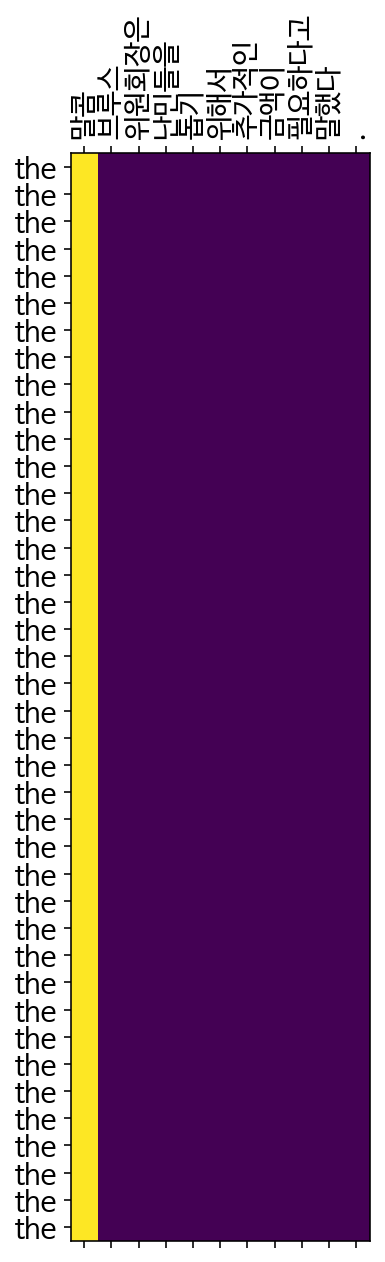

In [51]:
sample = kor_raw[29]
translate(sample, encoder, decoder)